In [9]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [10]:
accelerometer = pd.read_csv("SensorData_Acc_0.csv")
#rotation = pd.read_csv("SensorData_Rot_0.csv")

del accelerometer["Unnamed: 5"]

print(accelerometer)

accelerometer.columns = ["ax", "ay", "az", "timestamp", "label"]
accelerometer.index = accelerometer["timestamp"]

#rotation.columns = ["rx", "ry", "rz", "timestamp", "label"]
#rotation.index = rotation["timestamp"]

#accelerometer.join(rotation, lsuffix='_caller', rsuffix='_other')

# 50 hz sampling rate, 600 sample/seconds, discard first two seconds of data
N_FIRST = 600 * 2
accelerometer = accelerometer.iloc[N_FIRST: , :]

N_FIRST = 600 * 2
#rotation = rotation.iloc[N_FIRST: , :]

# Number of rows to drop
N_LAST = 600
 
# Removing last n rows
accelerometer = accelerometer.iloc[:-N_LAST]

print(accelerometer.shape)

mapping = {'PICKUP': 1, 'PUTDOWN': 2, 'OTHER': 3}
accelerometer.replace({'label': mapping})

accelerometer.label = [mapping[item] for item in accelerometer.label]

print(accelerometer)

training_data, testing_data = train_test_split(accelerometer, test_size=0.2, random_state=25)

training_labels = training_data["label"]
del training_data["label"]

testing_labels = testing_data["label"]
del testing_data["label"]

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

print(training_data)

       -2.142  2.952  8.848  963299515240  PUTDOWN
0      -2.166  3.005  8.857  9.633026e+11  PUTDOWN
1      -2.185  3.067  8.834  9.633115e+11  PUTDOWN
2      -2.201  3.182  8.730  9.633215e+11  PUTDOWN
3      -2.188  3.283  8.615  9.633315e+11  PUTDOWN
4      -2.222  3.374  8.545  9.633426e+11  PUTDOWN
...       ...    ...    ...           ...      ...
11312  -2.710  4.588  7.981  1.117767e+12    OTHER
11313  -2.642  4.362  8.120  1.117777e+12    OTHER
11314  -2.580  4.129  8.308  1.117787e+12    OTHER
11315  -2.543  3.918  8.462  1.117797e+12    OTHER
11316  -2.529  3.000    NaN           NaN      NaN

[11317 rows x 5 columns]
(9517, 5)
                 ax     ay     az     timestamp  label
timestamp                                             
9.845011e+11  1.271  2.204  7.388  9.845011e+11      2
9.845111e+11  1.539  2.232  7.024  9.845111e+11      2
9.845211e+11  1.923  2.468  6.737  9.845211e+11      2
9.845312e+11  2.341  2.649  5.985  9.845312e+11      2
9.845411e+11  2.777  2

# New Section

In [11]:
model = models.Sequential()
model.add(tf.keras.layers.Dense(training_data.shape[0], input_shape=(training_data.shape[1],), activation='sigmoid'))

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(training_data, training_labels, epochs=50, validation_data=(testing_data, testing_labels))
model.save(".")

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


236/238 [============================>.] - ETA: 0s - loss: 3402295296.0000 - accuracy: 0.5907

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


238/238 [==============================] - 2s 6ms/step - loss: 3375515648.0000 - accuracy: 0.5921 - val_loss: 309480768.0000 - val_accuracy: 0.1008
Epoch 2/50
238/238 [==============================] - 1s 5ms/step - loss: 123241928.0000 - accuracy: 0.6988 - val_loss: 111277864.0000 - val_accuracy: 0.8051
Epoch 3/50
238/238 [==============================] - 1s 5ms/step - loss: 145621648.0000 - accuracy: 0.7021 - val_loss: 389044800.0000 - val_accuracy: 0.8051
Epoch 4/50
238/238 [==============================] - 1s 5ms/step - loss: 207222368.0000 - accuracy: 0.7066 - val_loss: 153146400.0000 - val_accuracy: 0.8051
Epoch 5/50
238/238 [==============================] - 1s 5ms/step - loss: 141576224.0000 - accuracy: 0.6974 - val_loss: 34287176.0000 - val_accuracy: 0.0940
Epoch 6/50
238/238 [==============================] - 1s 5ms/step - loss: 153315808.0000 - accuracy: 0.6980 - val_loss: 132726264.0000 - val_accuracy: 0.8051
Epoch 7/50
238/238 [==============================] - 1s 5ms/st

60/60 - 0s - loss: 259854624.0000 - accuracy: 0.8051 - 189ms/epoch - 3ms/step


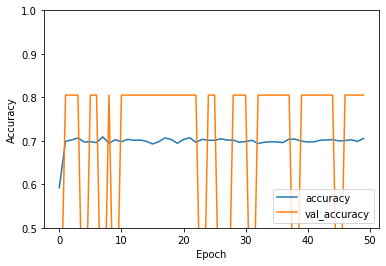

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(testing_data,  testing_labels, verbose=2)

In [16]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(".") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)